# Load and Preprocess Data 

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D , Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import regularizers



In [23]:

IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# Data Augmentation for training to improve generalization
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,           # Random rotations
    width_shift_range=0.2,       # Random horizontal shift
    height_shift_range=0.2,      # Random vertical shift
    shear_range=0.2,             # Shear transformation
    zoom_range=0.2,              # Zoom in/out
    horizontal_flip=True,        # Flip images horizontally
    fill_mode='nearest'          # How to fill newly created pixels
).flow_from_directory(
    "resource/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Validation generator (no augmentation, just rescaling)
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "resource/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Test generator (no augmentation, shuffle=False)
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    "resource/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Important to leave it as False during evaluation
)

Found 5039 images belonging to 4 classes.
Found 1080 images belonging to 4 classes.
Found 1080 images belonging to 4 classes.


# Load and Fine-Tune EfficientNet

In [ ]:
all_classes = np.concatenate([
    train_gen.classes,
    val_gen.classes,
    test_gen.classes
])

# Count how many images per class
class_counts = Counter(all_classes)

# Get class label names
class_labels = train_gen.class_indices
idx_to_class = {v: k for k, v in class_labels.items()}

# Print results
for class_idx, count in class_counts.items():
    print(f"Class '{idx_to_class[class_idx]}': {count} images")

Class 'Anthracnose': 2000 images
Class 'Bacterial_Spot': 1200 images
Class 'Healthy_Leaf': 1999 images
Class 'Pest_Damage': 2000 images


In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)  # Add dropout layer
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)                 
x = Dropout(0.5)(x)  # Add dropout layer
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze base model initially
base_model.trainable = False


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# Fine-Tune

Unfreeze base layers and fine-tune at lower LR:

### add EarlyStopping


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=3,             # Stop after 3 epochs with no improvement
    restore_best_weights=True # Restore weights from the best epoch
)

reduce_lr = ReduceLROnPlateau (monitor='val_loss',
                            factor=0.5,
                            patience=2, 
                            min_lr=1e-6)


In [ ]:
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-3), 
            loss='categorical_crossentropy', 
            metrics=['accuracy', Precision(), Recall()],
)

history = model.fit(train_gen, 
                    validation_data=val_gen,
                    epochs=10,
                    callbacks=[early_stop,reduce_lr])


c:\Users\user\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 15/315 ━━━━━━━━━━━━━━━━━━━━ 5:44 1s/step - accuracy: 0.3285 - loss: 1.3294

KeyboardInterrupt: 

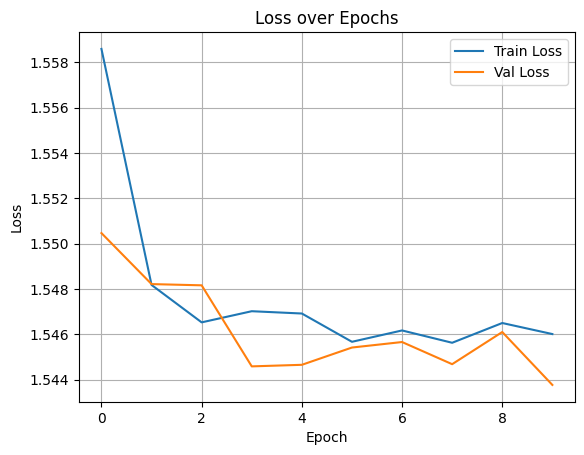

In [9]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

# Define a function to build the model
def build_model(hp):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Hyperparameters for tuning
    dropout_rate_1 = hp.Float('dropout_rate_1', min_value=0.2, max_value=0.5, step=0.1)
    dropout_rate_2 = hp.Float('dropout_rate_2', min_value=0.3, max_value=0.6, step=0.1)
    num_neurons_1 = hp.Int('num_neurons_1', min_value=64, max_value=512, step=64)
    num_neurons_2 = hp.Int('num_neurons_2', min_value=64, max_value=512, step=64)
    l2_reg = hp.Float('l2_reg', min_value=1e-5, max_value=1e-3, sampling='LOG')
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(dropout_rate_1)(x)  # Add dropout layer with hyperparameter
    x = Dense(num_neurons_1, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)  # Add L2 regularization
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate_2)(x)  # Add second dropout layer
    x = Dense(num_neurons_2, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    output = Dense(train_gen.num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    
    # Freeze the base model
    base_model.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Initialize Keras Tuner with Random Search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,
    directory='my_dir',
    project_name='hyperparameter_tuning'
)

# Perform the hyperparameter search
tuner.search(train_gen, epochs=10, validation_data=val_gen)

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print best hyperparameters
print(f'Best Hyperparameters: {best_hyperparameters.values}')

# Optionally, you can train the best model on more epochs
best_model.fit(train_gen, epochs=20, validation_data=val_gen)
